In [ ]:
#install Kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khalidredwan","key":"3505996a82c557afd9713e97f12c0aab"}'}

In [ ]:
#create kaggle folder
! mkdir ~/.kaggle

In [ ]:
#copy the kaggle.json to created folder
! cp kaggle.json ~/.kaggle/

In [ ]:
#Permission for json to act
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 73% 25.0M/34.1M [00:00<00:00, 64.7MB/s]
100% 34.1M/34.1M [00:00<00:00, 135MB/s] 


In [ ]:
!unzip alzheimers-dataset-4-class-of-images.zip

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16,preprocess_input
from PIL import Image, ImageOps

In [ ]:
from __future__ import division

import numpy as np
from scipy.signal import convolve2d

def lpq(img,winSize=3,freqestim=1,mode='nh'):
    rho=0.90

    STFTalpha=1/winSize  # alpha in STFT approaches (for Gaussian derivative alpha=1)
    sigmaS=(winSize-1)/4 # Sigma for STFT Gaussian window (applied if freqestim==2)
    sigmaA=8/(winSize-1) # Sigma for Gaussian derivative quadrature filters (applied if freqestim==3)

    convmode='valid' # Compute descriptor responses only on part that have full neigborhood. Use 'same' if all pixels are included (extrapolates np.image with zeros).

    img=np.float64(img) # Convert np.image to double
    r=(winSize-1)/2 # Get radius from window size
    x=np.arange(-r,r+1)[np.newaxis] # Form spatial coordinates in window

    if freqestim==1:  #  STFT uniform window
        #  Basic STFT filters
        w0=np.ones_like(x)
        w1=np.exp(-2*np.pi*x*STFTalpha*1j)
        w2=np.conj(w1)

    ## Run filters to compute the frequency response in the four points. Store np.real and np.imaginary parts separately
    # Run first filter
    filterResp1=convolve2d(convolve2d(img,w0.T,convmode),w1,convmode)
    filterResp2=convolve2d(convolve2d(img,w1.T,convmode),w0,convmode)
    filterResp3=convolve2d(convolve2d(img,w1.T,convmode),w1,convmode)
    filterResp4=convolve2d(convolve2d(img,w1.T,convmode),w2,convmode)

    # Initilize frequency domain matrix for four frequency coordinates (np.real and np.imaginary parts for each frequency).
    freqResp=np.dstack([filterResp1.real, filterResp1.imag,
                        filterResp2.real, filterResp2.imag,
                        filterResp3.real, filterResp3.imag,
                        filterResp4.real, filterResp4.imag])

    ## Perform quantization and compute LPQ codewords
    inds = np.arange(freqResp.shape[2])[np.newaxis,np.newaxis,:]
    LPQdesc=((freqResp>0)*(2**inds)).sum(2)

    ## Switch format to uint8 if LPQ code np.image is required as output
    if mode=='im':
        LPQdesc=np.uint8(LPQdesc)

    ## Histogram if needed
    if mode=='nh' or mode=='h':
        LPQdesc=np.histogram(LPQdesc.flatten(),range(256))[0]

    ## Normalize histogram if needed
    if mode=='nh':
        LPQdesc=LPQdesc/LPQdesc.sum()

    # print(LPQdesc)
    
    return LPQdesc

In [ ]:
W = 512 # The default size for ResNet is 224 but resize to .5 to save memory size
H = 512 # The default size for ResNet is 224 but resize to .5 to save memory size

label_to_class = {
    'MildDemented': 0,
    'ModerateDemented': 1,
    'NonDemented': 2,
    'VeryMildDemented':3
}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(dir_name='/content/Alzheimer_s Dataset', label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for j in ['/train','/test']:
        for label_name in os.listdir(dir_name+str(j)):
            cls = label_to_class[label_name]

            for img_name in os.listdir('/'.join([dir_name+str(j), label_name])):
                img = load_img('/'.join([dir_name+str(j), label_name, img_name]), target_size=(W, H))
                # print(type(img))
                img = img_to_array(img)
                B, G, R = img[:,:,2], img[:,:,1], img[:,:,0]
                img = 0.1140 * B + 0.5870 * G + 0.2989 * R
                LPQdesc = lpq(img)
                # print(type(LPQdesc))
                f = tf.keras.utils.array_to_img(LPQdesc)
                f.show()
                # plt.imshow(img, cmap='gray')
                # plt.show()
                # print(type(img))
                img = img_to_array(img)
                # print(type(img))
                Images.append(img)
                Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)
    
    return Images, Classes

In [ ]:
Images, Classes = get_images()

Images.shape, Classes.shape

ValueError: ignored

In [ ]:
## split train / test

indices_train, indices_test = train_test_split(list(range(Images.shape[0])), train_size=0.8, test_size=0.2, shuffle=True)

x_train = Images[indices_train]
y_train = Classes[indices_train]
x_test = Images[indices_test]
y_test = Classes[indices_test]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5120, 224, 224, 3), (5120,), (1280, 224, 224, 3), (1280,))

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

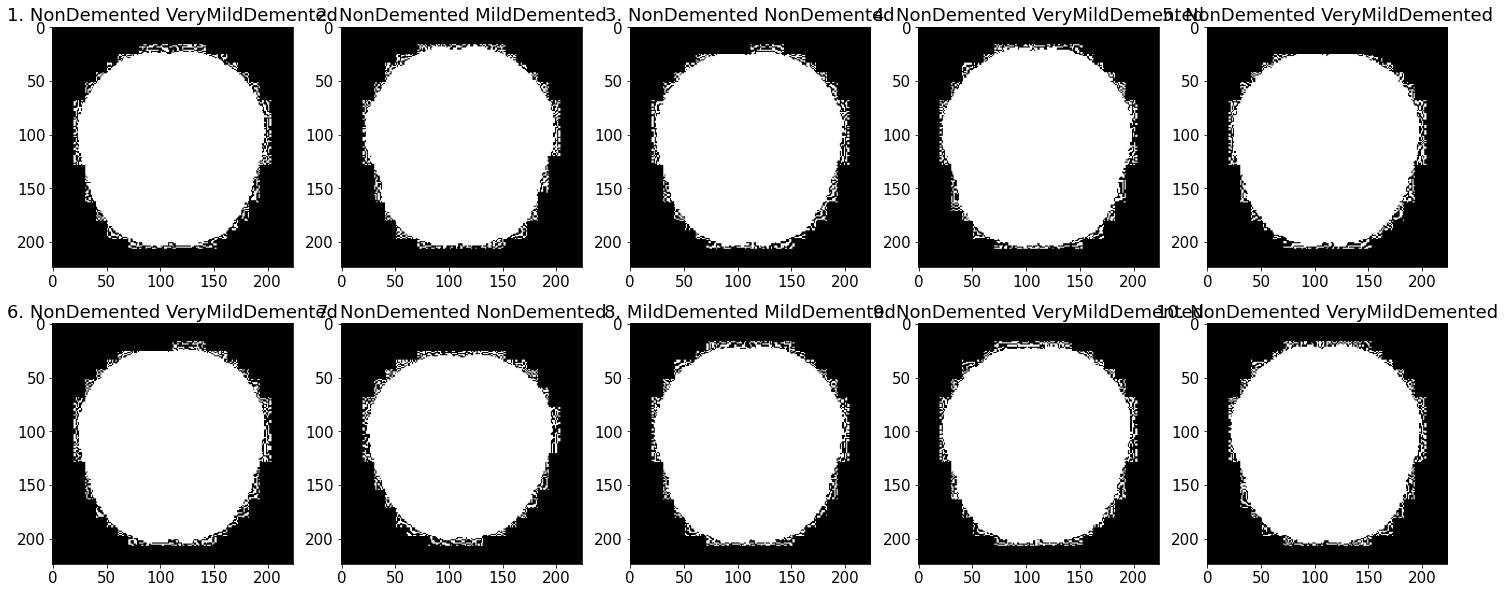

In [ ]:
from keras.utils import np_utils
## to one-hot

y_train = keras.utils.np_utils.to_categorical(y_train, n_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, n_classes)

y_train.shape, y_test.shape

## to image data generator

datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    rotation_range=30,                       # randomly rotate images in the range
    zoom_range=0.1,                          # Randomly zoom image
    width_shift_range=0.1,                   # randomly shift images horizontally
    height_shift_range=0.1,                  # randomly shift images vertically
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=False,                     # randomly flip images vertically
    validation_split=0.2
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)
IMG_SHAPE = (W,H,3)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(4,activation='softmax')
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  keras.layers.Dense(4096, activation='relu'),
  keras.layers.Dense(2048, activation='relu'),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  prediction_layer
])
model.summary()

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


#x_train,y_train = datagen_train.flow(x_train, y_train, batch_size=32,
#         subset='training')
#x_val, y_val = datagen_train.flow(x_train, y_train, batch_size=8,
#         subset='validation')
checkpoint = keras.callbacks.ModelCheckpoint("mri_resnet50.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')
history = model.fit(datagen_train.flow(x_train, y_train, batch_size=32,
         subset='training'),
                    epochs=10,
                    validation_data=datagen_train.flow(x_train, y_train, batch_size=8,
         subset='validation'),callbacks=[checkpoint,early]
                    )

test_loss, test_acc = model.evaluate(datagen_test.flow(x_test, y_test, batch_size=32
         ), verbose=2)
print(test_acc)

CATEGORIES = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']

fig=plt.figure(figsize=(25, 10))
columns = 5
rows = 2
plt.rc('font', size=15)
j=100
for i in range(1,11):
    
    prediction = model.predict(np.expand_dims(x_test[i+j],axis =0))
    prediction= list(prediction[0])
    prediction = CATEGORIES[prediction.index(max(prediction))]
    actual = CATEGORIES[np.argmax(y_test[i+j])]
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(x_test[i+j])
    ax.set_title(str(i)+'. '+prediction+' '+ actual)
plt.show()    
    

